In [1]:
import os
from functools import reduce

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import DataFrame, Row, SparkSession
from pyspark.sql.functions import rand, when, col

In [2]:
image = "ressource/image/train"
augmented_image_folder = "ressource/image/augmented_train"

db_url = "jdbc:mysql://localhost:3306/wildlens"
db_properties = { "user": "root",
                  "password": "root",
                  "driver": "com.mysql.cj.jdbc.Driver" }
mysql_driver_path = os.path.abspath("installation/mysql-connector-j-9.1.0.jar")

In [3]:
# Initialisation de SparkSession
spark = SparkSession.builder \
    .appName("WildLens ETL - MSPR 24-25") \
    .config("spark.jars", mysql_driver_path) \
    .getOrCreate()

print("✅ Spark initialisé avec le driver MySQL :", mysql_driver_path)
print("🔗 Driver chargé :", spark.sparkContext.getConf().get("spark.jars"))


25/03/20 14:48:55 WARN Utils: Your hostname, cedric-galaxy-book resolves to a loopback address: 127.0.1.1; using 10.192.205.76 instead (on interface wlo1)
25/03/20 14:48:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/03/20 14:48:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


✅ Spark initialisé avec le driver MySQL : /home/cedric/PycharmProjects/MSPR_ETL/ETL/installation/mysql-connector-j-9.1.0.jar
🔗 Driver chargé : /home/cedric/PycharmProjects/MSPR_ETL/ETL/installation/mysql-connector-j-9.1.0.jar


In [4]:
try:
    df_tables = spark.read \
        .format("jdbc") \
        .option("url", db_url) \
        .option("dbtable", "information_schema.tables") \
        .option("user", "root") \
        .option("password", "root") \
        .option("driver", "com.mysql.cj.jdbc.Driver") \
        .load()

    df_tables.filter(df_tables["TABLE_SCHEMA"] == "wildlens").select("TABLE_NAME").show()

    print("✅ Connexion à MySQL réussie et tables listées avec succès !")

except Exception as e:
    print(f"❌ Erreur de connexion à MySQL : {e}")

❌ Erreur de connexion à MySQL : An error occurred while calling o72.load.
: com.mysql.cj.jdbc.exceptions.CommunicationsException: Communications link failure

The last packet sent successfully to the server was 0 milliseconds ago. The driver has not received any packets from the server.
	at com.mysql.cj.jdbc.exceptions.SQLError.createCommunicationsException(SQLError.java:165)
	at com.mysql.cj.jdbc.exceptions.SQLExceptionsMapping.translateException(SQLExceptionsMapping.java:55)
	at com.mysql.cj.jdbc.ConnectionImpl.createNewIO(ConnectionImpl.java:837)
	at com.mysql.cj.jdbc.ConnectionImpl.<init>(ConnectionImpl.java:420)
	at com.mysql.cj.jdbc.ConnectionImpl.getInstance(ConnectionImpl.java:238)
	at com.mysql.cj.jdbc.NonRegisteringDriver.connect(NonRegisteringDriver.java:180)
	at org.apache.spark.sql.execution.datasources.jdbc.connection.BasicConnectionProvider.getConnection(BasicConnectionProvider.scala:49)
	at org.apache.spark.sql.execution.datasources.jdbc.connection.ConnectionProviderBas

# Gestion des métadonnées des espèces

 Dans un premier temps, nous scannons les dossiers disponibles afin d'en faire un dataframe et réutiliser ces informations.
 Puis nous récupérons les métadonnées depuis l'API Mistral grâce à un prompt optimisé (optimisation du grounding, du prompt engineering)
 un sleep de 3s a été ajouté afin d'éviter de trop spam l'API
 -- transféré dans un fichier à part --

In [5]:
folder_all_animals = [d for d in os.listdir("ressource/image/train") if os.path.isdir(os.path.join("ressource/image/train", d))]
df_all_animals = pd.DataFrame(folder_all_animals, columns=["Nom du dossier"])

# Gestion des images
Dans un premier temps, nous allons faire une première analyse des images: leurs nombre par espèces (donc, par dossier), leurs tailles moyenne, leurs poid moyen, etc...

Erreur avec l'image 2479.jpg: name 'Image' is not defined
Erreur avec l'image 2498.jpg: name 'Image' is not defined
Erreur avec l'image 2449.jpg: name 'Image' is not defined
Erreur avec l'image 2499.jpg: name 'Image' is not defined
Erreur avec l'image 2434.jpg: name 'Image' is not defined
Erreur avec l'image 2501.jpg: name 'Image' is not defined
Erreur avec l'image 2509.jpg: name 'Image' is not defined
Erreur avec l'image 2455.jpg: name 'Image' is not defined
Erreur avec l'image 2448.jpg: name 'Image' is not defined
Erreur avec l'image 2466.jpg: name 'Image' is not defined
Erreur avec l'image 2416.jpg: name 'Image' is not defined
Erreur avec l'image 2459.jpg: name 'Image' is not defined
Erreur avec l'image 2438.jpg: name 'Image' is not defined
Erreur avec l'image 2475.jpg: name 'Image' is not defined
Erreur avec l'image 2469.jpg: name 'Image' is not defined
Erreur avec l'image 2489.jpg: name 'Image' is not defined
Erreur avec l'image 2440.jpg: name 'Image' is not defined
Erreur avec l'

,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne
0,turkey,105,None,None
1,mouse,129,None,None
2,horse,71,None,None
3,gray_fox,126,None,None
4,goose,141,None,None
5,mink,139,None,None
6,coyote,123,None,None
7,bob_cat,171,None,None
8,skunk,122,None,None
9,black_bear,186,None,None


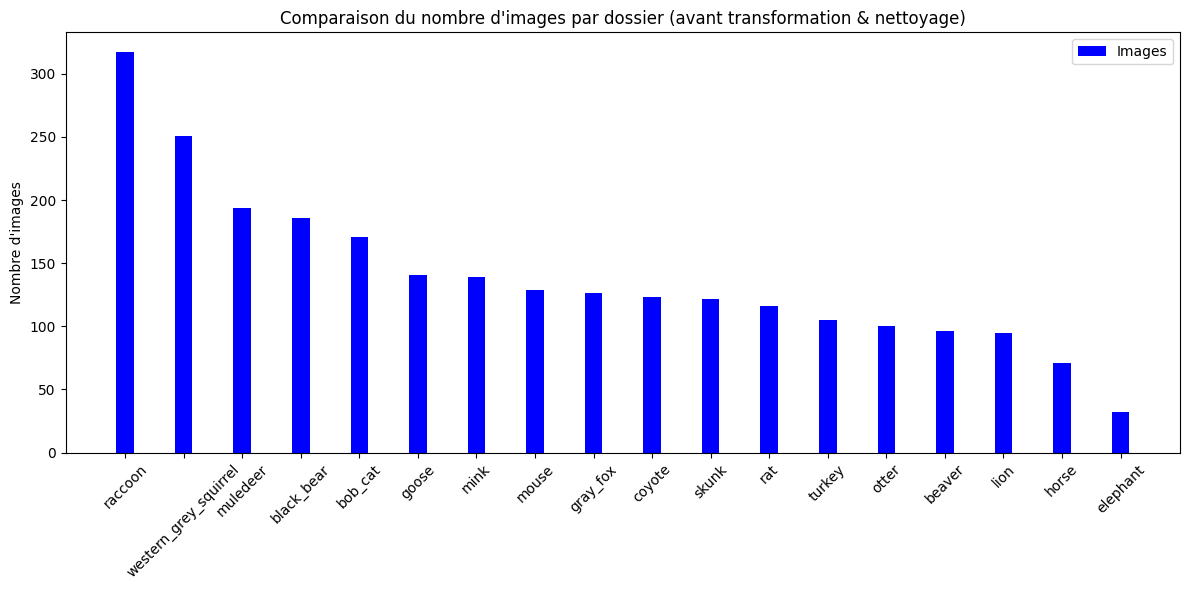

In [6]:
# Définition des chemins des datasets
image = "ressource/image/train"
# Fonction pour récupérer les infos des images d'un dossier (en gérant les dossiers absents)
def get_image_info(folder_path):
    if not os.path.exists(folder_path):  # 📌 Vérifie si le dossier existe
        return 0, None, None  # ⚠️ Si absent → 0 images et tailles nulles

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    num_images = len(image_files)

    if num_images == 0:
        return num_images, None, None  # Aucun fichier image

    widths, heights = [], []

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)
        except Exception as e:
            print(f"Erreur avec l'image {img_file}: {e}")

    avg_width = sum(widths) / len(widths) if widths else None
    avg_height = sum(heights) / len(heights) if heights else None

    return num_images, avg_width, avg_height

# Listes pour stocker les infos
image_data = []

# Parcourir chaque dossier et extraire les infos
for folder in df_all_animals["Nom du dossier"]:
    # ✂️ Images recadrées - entraînement
    folder_path_train = os.path.join(image, folder)
    num_images_train, avg_width_train, avg_height_train = get_image_info(folder_path_train)
    image_data.append([folder, num_images_train, avg_width_train, avg_height_train])

# Création des DataFrames
df_image = pd.DataFrame(image_data, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])

# Affichage du DataFrame de comparaison
display(df_image)

# 📊 Visualisation : Comparaison du nombre d'images par dossier
plt.figure(figsize=(12,6))

x_labels = df_image["Nom du dossier"]
x_range = range(len(x_labels))

plt.bar(x_range, df_image["Nombre d'images"], width=0.3, label="Images", color='blue')

plt.xticks([x for x in x_range], x_labels, rotation=90)  # Centrage des labels
plt.ylabel("Nombre d'images")
plt.title("Comparaison du nombre d'images par dossier")
plt.legend()
plt.tight_layout()
plt.show()



# Augmentation des images
## Data Augmentation et Transformation des Données
La Data Augmentation est une technique utilisée en apprentissage automatique, notamment en vision par ordinateur et en traitement du langage naturel (NLP), pour augmenter la diversité des données d'entraînement sans collecter de nouvelles données. Elle permet de rendre les modèles plus robustes et d'améliorer leur généralisation.

- Calculer la Mediane du nombre des images
- Determiner le Q3 afin que le nombre d'image finale de chaque animale se rapproche
- Calculer le coefficient de multiplication pour chaque classe d'animaux
- Modifier et sauvegarder les nouvelles images

In [7]:
median_images = df_image["Nombre d'images"].median()
q3_images = df_image["Nombre d'images"].quantile(0.75)

print(f"Médiane: {median_images}, Q3: {q3_images}")

Médiane: 124.5, Q3: 163.5


In [8]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import albumentations as A

os.makedirs(augmented_image_folder, exist_ok=True)
df_image["Coeff"] = np.ceil(q3_images / df_image["Nombre d'images"])

augmentation = A.Compose([
    A.HorizontalFlip(p=0.5), # Flip horizontal : effet miroir
    A.RandomBrightnessContrast(p=0.2), #Modification de la luminosité/contraste
    A.Rotate(limit=30, p=0.5), #Rotation aléatoire
    A.GaussNoise(p=0.1), #Ajout de bruit
    A.Resize(256, 256) #Redimensionnement en 256x256
])

for index, row in df_image.iterrows():
    if row["Coeff"] < 4 :
        folder_name = row["Nom du dossier"]
        coeff = int(row["Coeff"])

        original_folder = os.path.join(image, folder_name)
        augmented_folder = os.path.join(augmented_image_folder, folder_name)
        os.makedirs(augmented_folder, exist_ok=True)

        image_files = [f for f in os.listdir(original_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

        for img_file in image_files:
            img_path = os.path.join(original_folder, img_file)
            img = cv2.imread(img_path)

            if img is None:
                print(f"❌ Erreur de lecture de l'image {img_file}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            for i in range(coeff):
                augmented = augmentation(image=img)["image"]
                new_img_path = os.path.join(augmented_folder, f"aug_{i}_{img_file}")
                cv2.imwrite(new_img_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

print("✅ Data Augmentation terminée avec succès !")


/home/cedric/PycharmProjects/MSPR_ETL/ETL/env/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
25/03/20 14:49:10 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


✅ Data Augmentation terminée avec succès !


,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne,Coeff
0,turkey,210,256.0,256.0,2.0
1,mouse,258,256.0,256.0,2.0
2,horse,213,256.0,256.0,3.0
3,gray_fox,252,256.0,256.0,2.0
4,goose,282,256.0,256.0,2.0
5,mink,278,256.0,256.0,2.0
6,coyote,246,256.0,256.0,2.0
7,bob_cat,171,256.0,256.0,1.0
8,skunk,244,256.0,256.0,2.0
9,black_bear,186,256.0,256.0,1.0


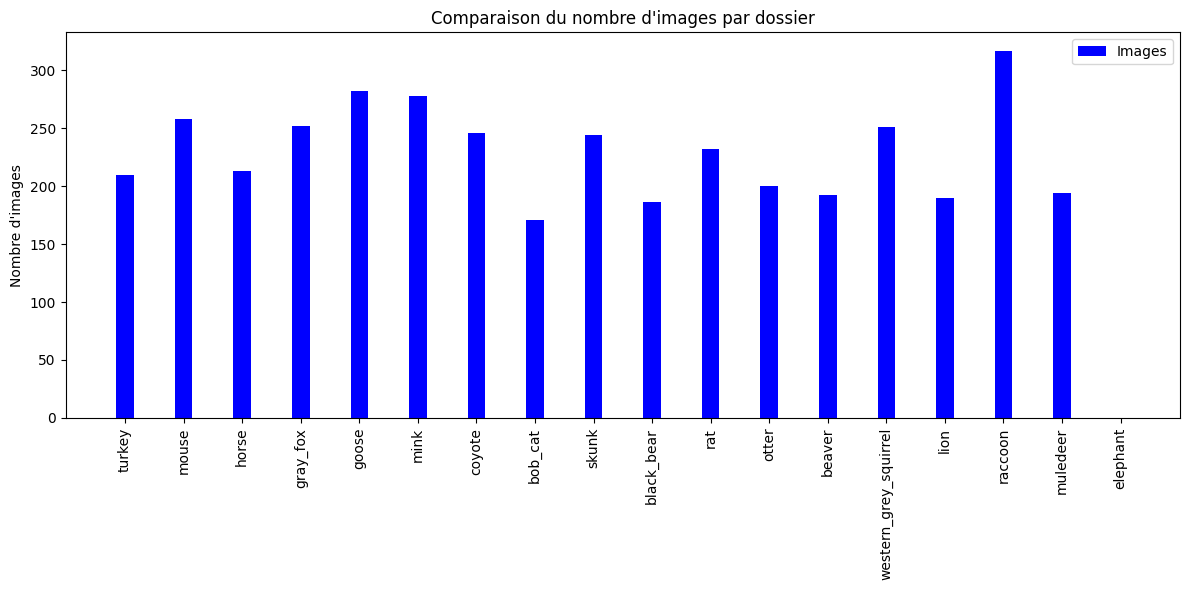

In [9]:
# Listes pour stocker les infos
image_data_new = []
image_new = "ressource/image/augmented_train"

# Parcourir chaque dossier et extraire les infos
for folder in df_all_animals["Nom du dossier"]:

    folder_path_train = os.path.join(image_new, folder)
    num_images_train, avg_width_train, avg_height_train = get_image_info(folder_path_train)
    image_data_new.append([folder, num_images_train, avg_width_train, avg_height_train])

# Création des DataFrames
image_data_new = pd.DataFrame(image_data_new, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])
image_data_new["Coeff"] = df_image["Coeff"]
# Affichage du DataFrame de comparaison
display(image_data_new)

# 📊 Visualisation : Comparaison du nombre d'images par dossier
plt.figure(figsize=(12,6))

x_labels = image_data_new["Nom du dossier"]
x_range = range(len(x_labels))

plt.bar(x_range, image_data_new["Nombre d'images"], width=0.3, label="Images", color='blue')

plt.xticks([x for x in x_range], x_labels, rotation=90)  # Centrage des labels
plt.ylabel("Nombre d'images")
plt.title("Comparaison du nombre d'images par dossier")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
display(image_data_new)

,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne,Coeff
0,turkey,210,256.0,256.0,2.0
1,mouse,258,256.0,256.0,2.0
2,horse,213,256.0,256.0,3.0
3,gray_fox,252,256.0,256.0,2.0
4,goose,282,256.0,256.0,2.0
5,mink,278,256.0,256.0,2.0
6,coyote,246,256.0,256.0,2.0
7,bob_cat,171,256.0,256.0,1.0
8,skunk,244,256.0,256.0,2.0
9,black_bear,186,256.0,256.0,1.0


## Labellisation
Le dataframe d'images et les métadata sont fusionnées afin que chaque image corresponde à des métadonnées : c'est la labélisation.

In [11]:
df_metadata = pd.read_csv("./ressource/metadata.csv")

df_merged = pd.merge(image_data_new, df_metadata, left_on='Nom du dossier', right_on='Espèce anglais', how='left')
df_merged = df_merged.drop(columns=["Nom du dossier", "Largeur Moyenne", "Hauteur Moyenne"])
print(df_merged)
df_merged.to_csv("./ressource/data_merged.csv", header=True)

if print(df_merged['Espèce anglais'].isna().sum()):
    print("Toutes les lignes ont trouvés une correspondance")
display(df_merged)

    Nombre d'images  Coeff         Espèce anglais           Espèce français  \
0               210    2.0                 turkey                     Dinde   
1               258    2.0                  mouse                    souris   
2               213    3.0                  horse                    cheval   
3               252    2.0               gray_fox               Renard gris   
4               282    2.0                  goose                       Oie   
5               278    2.0                   mink                     vison   
6               246    2.0                 coyote                    Coyote   
7               171    1.0                bob_cat           Chat domestique   
8               244    2.0                  skunk                    putois   
9               186    1.0             black_bear                 Ours noir   
10              232    2.0                    rat                       rat   
11              200    2.0                  otter   

,Nombre d'images,Coeff,Espèce anglais,Espèce français,Famille,Nom latin,Description,Population estimée,Localisation
0,210,2.0,turkey,Dinde,Phasianidae,Meleagris gallopavo,"Oiseau de grande taille au plumage coloré, ori...",550000000,États-Unis Mexique
1,258,2.0,mouse,souris,Muridae,Mus musculus,"Petite souris grise aux longues moustaches, vi...",500000000,"France, Royaume-Uni, États-Unis"
2,213,3.0,horse,cheval,équidés,Equus ferus caballus,"Mammifère quadrupède au corps puissant, au cou...",58000000,"France, États-Unis, Russie, Chine, Brésil, Mex..."
3,252,2.0,gray_fox,Renard gris,Canidae,Urocyon cinereoargenteus,Le renard gris est un petit canidé aux poils g...,5000000,États-Unis Mexique
4,282,2.0,goose,Oie,Anatidae,Anser anser,L'oie est un grand oiseau aquatique au plumage...,2500000,"Europe, Asie, Afrique du Nord"
5,278,2.0,mink,vison,Mustelidae,Neogale vison,Petit mammifère semi-aquatique au pelage brun-...,1000000,États-Unis Canada Russie
6,246,2.0,coyote,Coyote,Canidae,Canis latrans,"Le coyote est un canidé de taille moyenne, ave...",3000000,États-Unis Canada Mexique
7,171,1.0,bob_cat,Chat domestique,Felidae,Felis catus,Petit félin domestique au pelage court et aux ...,600000000,France États-Unis Chine Japon
8,244,2.0,skunk,putois,Mustelidae,Mephitis mephitis,Le skunk est un petit mammifère nocturne connu...,3000000,États-Unis Canada
9,186,1.0,black_bear,Ours noir,Ursidae,Ursus americanus,L'ours noir est un ours de taille moyenne avec...,900000,Canada États-Unis Mexique


# State
Ajout d'un state aléatoire sur chaque image.

70% de train (1)

15% de test (2)

15% de val (3)

Ceci servira prochainement pour l'entrainement du model de machine learning


In [12]:
df_merged_spark = spark.createDataFrame(df_merged)
image_new = "ressource/image/augmented_train"

df_dict = {}
for dossier in df_merged_spark.select("Espèce anglais").distinct().rdd.flatMap(lambda x: x).collect():
    folder_path = os.path.join(image_new, dossier)
    if os.path.exists(folder_path):
        df_images = spark.createDataFrame([(dossier, os.path.join(dossier, img)) for img in os.listdir(folder_path)],["Espèce anglais", "Chemin Relatif"])
        df_dict[dossier] = df_images.join(df_merged_spark.select("Espèce anglais"), on="Espèce anglais")
train_ratio = 0.7
val_ratio = 0.15

for dossier, df in df_dict.items():
    df = df.withColumn("rand_val", rand())
    df = df.withColumn(
        "state",
        when(col("rand_val") <= train_ratio, 1)
        .when(col("rand_val") <= (train_ratio + val_ratio), 2)
        .otherwise(3)
    )
    df_dict[dossier] = df
    df.write.mode("overwrite").parquet(f"ressource/dataframes_parquet/{dossier}")
    df.write.mode("overwrite").csv(f"ressource/dataframes_csv/{dossier}")
    print(f"✅ State ajouté et fichier enregistré pour {dossier}")
if df_dict:
    df_final = reduce(DataFrame.unionAll, df_dict.values())
    print(f" Fusion complète ! Le DataFrame final contient {df_final.count()} images.")
    df_final.write.mode("overwrite").parquet("ressource/dataframes_parquet/all_images")
    df_final.coalesce(1).write.mode("overwrite").csv("ressource/dataframes_csv/all_images", header=True)
else:
    print("⚠️ Aucun DataFrame à fusionner !")

✅ State ajouté et fichier enregistré pour turkey
✅ State ajouté et fichier enregistré pour mouse
✅ State ajouté et fichier enregistré pour horse
✅ State ajouté et fichier enregistré pour gray_fox
✅ State ajouté et fichier enregistré pour goose
✅ State ajouté et fichier enregistré pour mink
✅ State ajouté et fichier enregistré pour coyote
✅ State ajouté et fichier enregistré pour bob_cat
✅ State ajouté et fichier enregistré pour skunk
✅ State ajouté et fichier enregistré pour black_bear
✅ State ajouté et fichier enregistré pour rat
✅ State ajouté et fichier enregistré pour otter
✅ State ajouté et fichier enregistré pour beaver
✅ State ajouté et fichier enregistré pour western_grey_squirrel
✅ State ajouté et fichier enregistré pour lion
✅ State ajouté et fichier enregistré pour raccoon
✅ State ajouté et fichier enregistré pour muledeer


 Fusion complète ! Le DataFrame final contient 3916 images.


25/03/20 14:49:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/03/20 14:49:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
25/03/20 14:49:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
25/03/20 14:49:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
25/03/20 14:49:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


root
 |-- Espèce anglais: string (nullable = true)
 |-- Chemin Relatif: string (nullable = true)
 |-- rand_val: double (nullable = false)
 |-- state: integer (nullable = false)



+--------------+--------------------+-------------------+-----+
|Espèce anglais|      Chemin Relatif|           rand_val|state|
+--------------+--------------------+-------------------+-----+
|        turkey|turkey/aug_1_2493...|  0.771794627315874|    2|
|        turkey|turkey/aug_0_2442...| 0.9031221493765036|    3|
|        turkey|turkey/aug_1_2426...|  0.647523040513573|    1|
|        turkey|turkey/aug_0_2460...|0.06342162278420094|    1|
|        turkey|turkey/aug_1_2417...|0.40083585609940964|    1|
|        turkey|turkey/aug_1_2505...| 0.7460494537124468|    2|
|        turkey|turkey/aug_1_2440...| 0.2853812751133864|    1|
|        turkey|turkey/aug_0_2432...| 0.2912552895272775|    1|
|        turkey|turkey/aug_1_2466...|0.12050100008233866|    1|
|        turkey|turkey/aug_1_2458...| 0.5040809459950966|    1|
+--------------+--------------------+-------------------+-----+
only showing top 10 rows



Nombre total d'images : 3916
Colonnes : ['Espèce anglais', 'Chemin Relatif', 'rand_val', 'state']


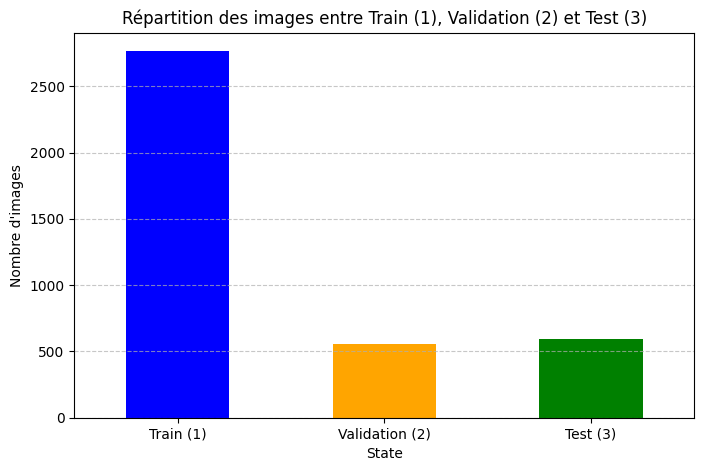

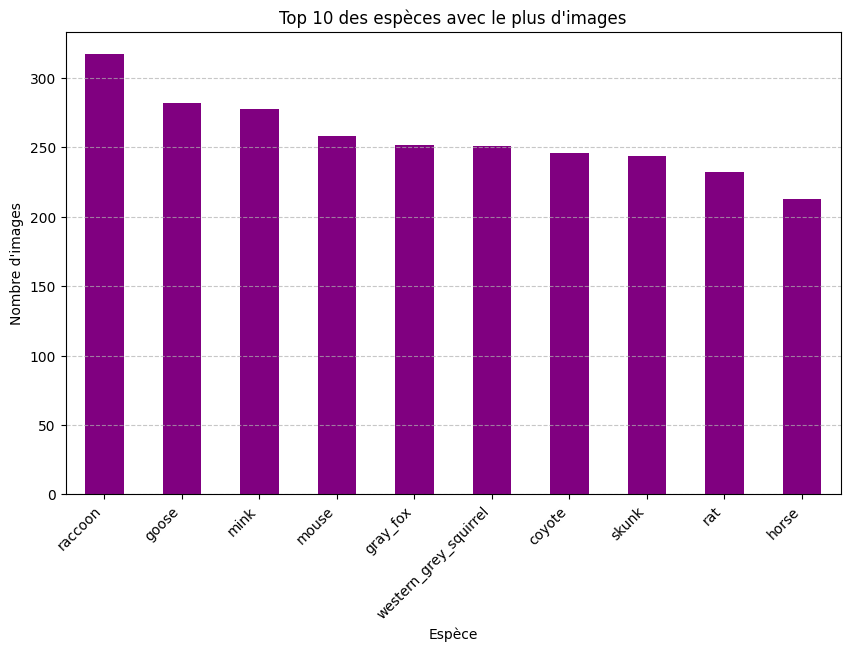

<Figure size 1000x600 with 0 Axes>

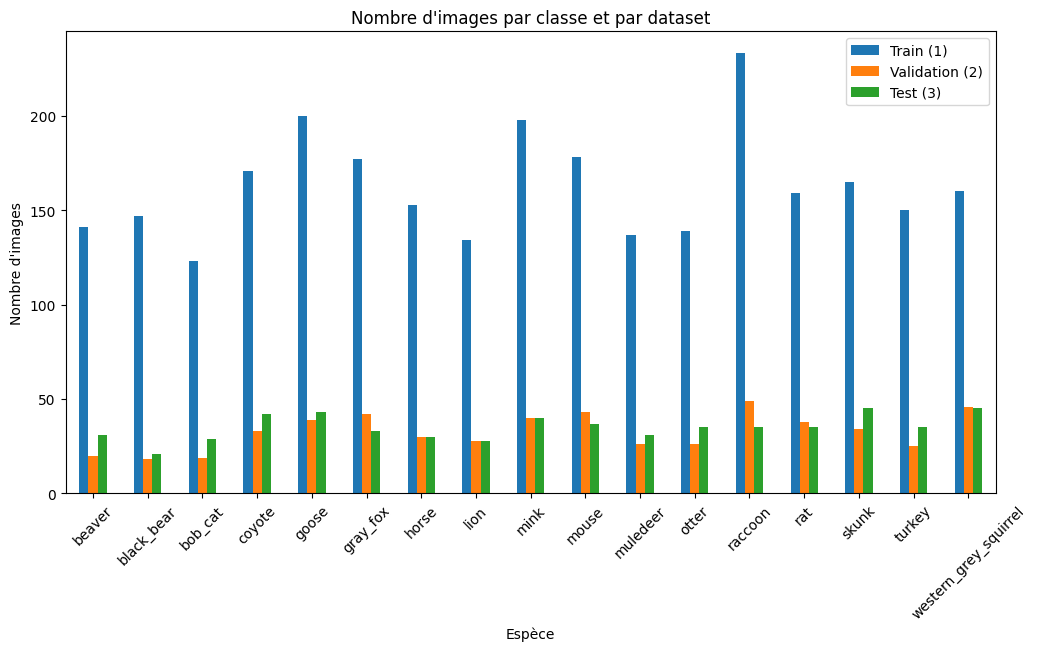

In [13]:
df_final.printSchema()
df_final.show(10)
print(f"Nombre total d'images : {df_final.count()}")
print(f"Colonnes : {df_final.columns}")

df_pandas = df_final.toPandas()

# Compter les occurrences des états (1 = train, 2 = val, 3 = test)
state_counts = df_pandas["state"].value_counts().sort_index()

# 📊 Création du graphique
plt.figure(figsize=(8, 5))
state_counts.plot(kind='bar', color=['blue', 'orange', 'green'])

plt.xlabel("State")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images entre Train (1), Validation (2) et Test (3)")
plt.xticks(ticks=[0, 1, 2], labels=["Train (1)", "Validation (2)", "Test (3)"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

# Compter le nombre d'images par espèce
species_counts = df_pandas["Espèce anglais"].value_counts().head(10)  # Top 10

# 📊 Création du graphique
plt.figure(figsize=(10, 6))
species_counts.plot(kind='bar', color='purple')

plt.xlabel("Espèce")
plt.ylabel("Nombre d'images")
plt.title("Top 10 des espèces avec le plus d'images")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

# 📊 2. Répartition des images par classe et par dataset (Histogramme groupé)
df_final_pandas = df_final.toPandas()
plt.figure(figsize=(10, 6))
df_grouped = df_final_pandas.groupby(["Espèce anglais", "state"]).size().unstack()
df_grouped.plot(kind="bar", figsize=(12, 6))
plt.title("Nombre d'images par classe et par dataset")
plt.xlabel("Espèce")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.legend(["Train (1)", "Validation (2)", "Test (3)"])


In [14]:
df_final.describe()

DataFrame[summary: string, Espèce anglais: string, Chemin Relatif: string, rand_val: string, state: string]

In [15]:
print("Colonnes de df_facts :", df_final.columns)
print(df_final.describe())

Colonnes de df_facts : ['Espèce anglais', 'Chemin Relatif', 'rand_val', 'state']
DataFrame[summary: string, Espèce anglais: string, Chemin Relatif: string, rand_val: string, state: string]


In [16]:
df_existing = spark.read.jdbc(url=db_url, table="wildlens_etat", properties=db_properties)

if df_existing.count() == 0:
    print("La table wildlens_etat est vide, insertion des données...")

    df_etat = spark.createDataFrame([
        Row(id_etat=1, type="train"),
        Row(id_etat=2, type="test"),
        Row(id_etat=3, type="validation")
    ])

    df_etat.write.mode("append").jdbc(url=db_url, table="wildlens_etat", properties=db_properties)

Py4JJavaError: An error occurred while calling o982.jdbc.
: com.mysql.cj.jdbc.exceptions.CommunicationsException: Communications link failure

The last packet sent successfully to the server was 0 milliseconds ago. The driver has not received any packets from the server.
	at com.mysql.cj.jdbc.exceptions.SQLError.createCommunicationsException(SQLError.java:165)
	at com.mysql.cj.jdbc.exceptions.SQLExceptionsMapping.translateException(SQLExceptionsMapping.java:55)
	at com.mysql.cj.jdbc.ConnectionImpl.createNewIO(ConnectionImpl.java:837)
	at com.mysql.cj.jdbc.ConnectionImpl.<init>(ConnectionImpl.java:420)
	at com.mysql.cj.jdbc.ConnectionImpl.getInstance(ConnectionImpl.java:238)
	at com.mysql.cj.jdbc.NonRegisteringDriver.connect(NonRegisteringDriver.java:180)
	at org.apache.spark.sql.execution.datasources.jdbc.connection.BasicConnectionProvider.getConnection(BasicConnectionProvider.scala:49)
	at org.apache.spark.sql.execution.datasources.jdbc.connection.ConnectionProviderBase.create(ConnectionProvider.scala:102)
	at org.apache.spark.sql.jdbc.JdbcDialect.$anonfun$createConnectionFactory$1(JdbcDialects.scala:161)
	at org.apache.spark.sql.jdbc.JdbcDialect.$anonfun$createConnectionFactory$1$adapted(JdbcDialects.scala:157)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCRDD$.getQueryOutputSchema(JDBCRDD.scala:63)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCRDD$.resolveTable(JDBCRDD.scala:58)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCRelation$.getSchema(JDBCRelation.scala:241)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:37)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:346)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:229)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:211)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:211)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:172)
	at org.apache.spark.sql.DataFrameReader.jdbc(DataFrameReader.scala:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: com.mysql.cj.exceptions.CJCommunicationsException: Communications link failure

The last packet sent successfully to the server was 0 milliseconds ago. The driver has not received any packets from the server.
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:53)
	at java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:502)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:486)
	at com.mysql.cj.exceptions.ExceptionFactory.createException(ExceptionFactory.java:52)
	at com.mysql.cj.exceptions.ExceptionFactory.createException(ExceptionFactory.java:95)
	at com.mysql.cj.exceptions.ExceptionFactory.createException(ExceptionFactory.java:140)
	at com.mysql.cj.exceptions.ExceptionFactory.createCommunicationsException(ExceptionFactory.java:156)
	at com.mysql.cj.protocol.a.NativeSocketConnection.connect(NativeSocketConnection.java:79)
	at com.mysql.cj.NativeSession.connect(NativeSession.java:142)
	at com.mysql.cj.jdbc.ConnectionImpl.connectOneTryOnly(ConnectionImpl.java:961)
	at com.mysql.cj.jdbc.ConnectionImpl.createNewIO(ConnectionImpl.java:825)
	... 30 more
Caused by: java.net.ConnectException: Connection refused
	at java.base/sun.nio.ch.Net.connect0(Native Method)
	at java.base/sun.nio.ch.Net.connect(Net.java:589)
	at java.base/sun.nio.ch.Net.connect(Net.java:578)
	at java.base/sun.nio.ch.NioSocketImpl.connect(NioSocketImpl.java:583)
	at java.base/java.net.SocksSocketImpl.connect(SocksSocketImpl.java:327)
	at java.base/java.net.Socket.connect(Socket.java:751)
	at com.mysql.cj.protocol.StandardSocketFactory.connect(StandardSocketFactory.java:144)
	at com.mysql.cj.protocol.a.NativeSocketConnection.connect(NativeSocketConnection.java:53)
	... 33 more


In [ ]:
metadata_path = "ressource/data_merged.csv"
df_meta = spark.read.option("header", True).option("sep", ",").csv(metadata_path)

df_existing = spark.read.jdbc(url=db_url, table="wildlens_facts", properties=db_properties)

if df_existing.count() == 0:

    print("La table wildlens_facts est vide, insertion des données...")

    df_facts = df_meta.select(
        "Espèce français", "Famille", "Nom latin", "Description", "Population estimée", "Localisation", "Espèce anglais",
        "Nombre d'images","Coeff"
    ).dropDuplicates()

    df_facts = (df_facts.withColumnRenamed("Espèce anglais", "nom_en")
                .withColumnRenamed("Population estimée", "population_estimee")
                .withColumnRenamed("Nombre d'images", "nombre_image")
                .withColumnRenamed("Espèce français", "nom_fr")
                .withColumnRenamed("Nom latin", "nom_latin")
                .withColumnRenamed("Famille", "famille")
                .withColumnRenamed("Localisation", "localisation")
                .withColumnRenamed("Coeff", "coeff_multiplication"))

    df_facts.write.jdbc(url=db_url, table="wildlens_facts", mode="append", properties=db_properties)
    print(df_facts.head(5))
    print("✅ Table wildlens_facts mise à jour avec succès !")


In [ ]:
df_existing = spark.read.jdbc(url=db_url, table="wildlens_images", properties=db_properties)

if df_existing.count() == 0:

    df_images = spark.read.jdbc(url=db_url, table="wildlens_facts", properties=db_properties)
    df_id_espece = df_images.select("id_espece", "nom_en").distinct()

    if "id_espece" in df_final.columns:
        df_final = df_final.drop("id_espece")

    df_final = df_final.join(df_id_espece, df_final["Espèce anglais"] == df_id_espece["nom_en"], "left")

    df = df_final.select("Chemin Relatif", "id_espece", "state")
    df = (df.withColumnRenamed("Chemin Relatif", "image")
                .withColumnRenamed("id_espece", "id_espece")
                .withColumnRenamed("state", "id_etat"))

    df.write.jdbc(url=db_url, table="wildlens_images", mode="append", properties=db_properties)
    print("✅ Table wildlens_images mise à jour avec succès !")

In [ ]:
# Simuler df_final (reprenant la structure de ton code)
df_final = pd.DataFrame({
    "Espèce anglais": ["Lion", "Tigre", "Éléphant", "Zèbre"],
    "Chemin Relatif": ["img1.jpg", "img2.jpg", "img3.jpg", "img4.jpg"],
    "state": [1, 2, 1, 3]
})

# Simuler df_id_espece depuis la table wildlens_facts
df_id_espece = pd.DataFrame({
    "id_espece": [101, 102, 103, 104],
    "nom_en": ["Lion", "Tigre", "Éléphant", "Zèbre"]
})

# Vérifier et supprimer la colonne "id_espece" si elle existe déjà dans df_final
if "id_espece" in df_final.columns:
    df_final = df_final.drop(columns=["id_espece"])

# Effectuer la jointure entre df_final et df_id_espece
df_merged = df_final.merge(df_id_espece, left_on="Espèce anglais", right_on="nom_en", how="left")

# Sélectionner les colonnes pertinentes pour l'insertion en base
df_result = df_merged[["Chemin Relatif", "id_espece", "state"]].rename(
    columns={"Chemin Relatif": "image", "state": "id_etat"})

# Création de l'image de la jointure sous forme de tableau
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Affichage de df_final
axes[0].axis("tight")
axes[0].axis("off")
axes[0].table(cellText=df_final.values, colLabels=df_final.columns, cellLoc="center", loc="center")
axes[0].set_title("df_final")

# Affichage de df_id_espece
axes[1].axis("tight")
axes[1].axis("off")
axes[1].table(cellText=df_id_espece.values, colLabels=df_id_espece.columns, cellLoc="center", loc="center")
axes[1].set_title("df_id_espece (depuis wildlens_facts)")

# Affichage du DataFrame joint (df_result)
axes[2].axis("tight")
axes[2].axis("off")
axes[2].table(cellText=df_result.values, colLabels=df_result.columns, cellLoc="center", loc="center")
axes[2].set_title("df_final (prêt pour wildlens_images)")

plt.show()